In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

df = pd.read_csv('uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


How many rows and columns does the dataset contain?

In [2]:
df.shape

(200000, 9)

Are any of the columns missing values?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


Draw a histogram showing how many rows contain a passenger count of 1, how many contain a passenger count of 2, and so on.

<Axes: xlabel='passenger_count', ylabel='count'>

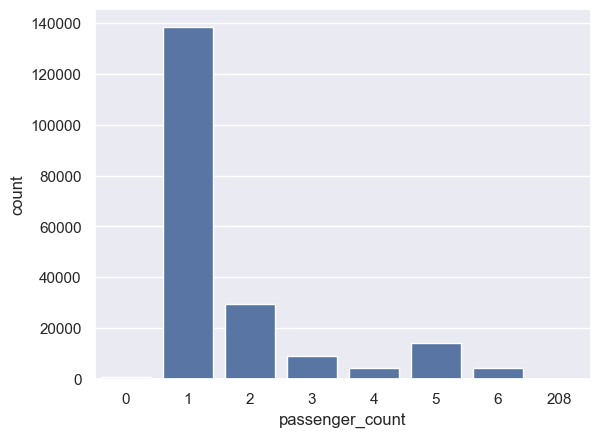

In [4]:
sns.countplot(x=df['passenger_count'])

Most of the rows in the dataset have a passenger count of 1. Remove all rows with multiple passengers and remove the "key" column from the dataset.

In [5]:
df = df[df['passenger_count'] == 1]
df = df.drop(['key', 'passenger_count'], axis=1)
df.head()

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,24238194,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217
1,27835199,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325
2,44984355,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647
5,44470845,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910
7,44195482,2.5,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000


How many rows and columns are left in the dataset?

In [6]:
df.shape

(138425, 7)

Find out how much influence input variables such as `latitude` and `longitude` have on the values in the "fare_amount" column.

In [10]:
numeric_df = df.select_dtypes(include=['number'])  # Select only numeric columns
corr_matrix = numeric_df.corr()  # Compute correlation matrix
corr_matrix['fare_amount'].sort_values(ascending=False)  # Display correlation with 'fare_amount'


fare_amount          1.000000
pickup_longitude     0.009522
dropoff_longitude    0.009388
Unnamed: 0           0.000581
pickup_latitude     -0.007403
dropoff_latitude    -0.012091
Name: fare_amount, dtype: float64

The numbers don't look very encouraging. Latitudes and longitudes have little to do with fare amounts, at least in their present form. And yet intuitively, they should have a *lot* do with fare amounts since they specify starting and ending points and longer rides incur higher fares.

Now comes the fun part: creating whole new columns of data that have more impact on the outcome — columns whose values are computed from values in other columns. Add columns specifying the day of the week (0=Monday, 1=Sunday, and so on), the hour of the day that the passenger was picked up (0-23), and the distance (through the air, not on the street) in miles that the ride covered. To compute distances, this code assumes that most rides are short and that it is therefore safe to ignore the curvature of the earth.

In [11]:
import datetime
from math import sqrt

for i, row in df.iterrows():
    dt = datetime.datetime.strptime(row['pickup_datetime'], '%Y-%m-%d %H:%M:%S UTC')
    df.at[i, 'day_of_week'] = dt.weekday()
    df.at[i, 'pickup_time'] = dt.hour
    x = (row['dropoff_longitude'] - row['pickup_longitude']) * 54.6 # 1 degree == 54.6 miles
    y = (row['dropoff_latitude'] - row['pickup_latitude']) * 69.0   # 1 degree == 69 miles
    distance = sqrt(x**2 + y**2)
    df.at[i, 'distance'] = distance
    
df.head()

,Unnamed: 0,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,day_of_week,pickup_time,distance
0,24238194,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,3.0,19.0,1.044567
1,27835199,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,4.0,20.0,1.525023
2,44984355,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,0.0,21.0,3.196405
5,44470845,4.9,2011-02-12 02:27:09 UTC,-73.969019,40.755910,-73.969019,40.755910,5.0,2.0,0.000000
7,44195482,2.5,2012-12-11 13:52:00 UTC,0.000000,0.000000,0.000000,0.000000,1.0,13.0,0.000000


Remove columns that are no longer needed.

In [12]:
df.drop(columns=['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], inplace=True)
df.head()

,Unnamed: 0,fare_amount,day_of_week,pickup_time,distance
0,24238194,7.5,3.0,19.0,1.044567
1,27835199,7.7,4.0,20.0,1.525023
2,44984355,12.9,0.0,21.0,3.196405
5,44470845,4.9,5.0,2.0,0.000000
7,44195482,2.5,1.0,13.0,0.000000


Run a correlation again.

In [13]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount    1.000000
day_of_week    0.012516
distance       0.010927
Unnamed: 0     0.000581
pickup_time   -0.017476
Name: fare_amount, dtype: float64

There still isn't a strong correlation between distance traveled and fare amount. Perhaps this will provide some clue as to why:

In [14]:
df.describe()

,Unnamed: 0,fare_amount,day_of_week,pickup_time,distance
count,1.384250e+05,138425.000000,138425.000000,138425.000000,138425.000000
mean,2.767942e+07,11.254158,2.971848,13.372794,16.018623
std,1.599722e+07,9.855264,1.930082,6.417891,634.719348
min,1.000000e+00,-10.900000,0.000000,0.000000,0.000000
25%,1.379461e+07,6.000000,1.000000,9.000000,0.760683
50%,2.771388e+07,8.500000,3.000000,14.000000,1.327296
75%,4.150225e+07,12.500000,5.000000,19.000000,2.410681
max,5.542357e+07,499.000000,6.000000,23.000000,161504.979693


The dataset contains outliers, and outliers frequently skew the results of machine-learning models (or prevent them from working at all). Filter the dataset by eliminating negative fare amounts and placing reasonable limits on fares and distance.

In [15]:
df = df[(df['distance'] > 1.0) & (df['distance'] < 10.0)]
df = df[(df['fare_amount'] > 0.0) & (df['fare_amount'] < 50.0)]
df.shape

(84358, 5)

Run a correlation again.

In [16]:
corr_matrix = df.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount    1.000000
distance       0.850258
Unnamed: 0    -0.001991
day_of_week   -0.002164
pickup_time   -0.020249
Name: fare_amount, dtype: float64

That looks better! The correlation between the day of the week, the hour of the day, and fare amount is still weak, but let's leave those columns in there since it makes sense that it might take longer to get from point A to point B during rush hour, or that traffic at 5:00 p.m. Friday might be different than traffic at 5:00 p.m. on Saturday.

# Train a regression model

Now it's time build a regression model and train it with the data prepared in the previous exercise. We'll try three different regression algorithms to determine which one produces the most accurate results, and use cross-validation to increase our confidence in those results. Start by splitting the data for training and testing.

In [17]:
from sklearn.model_selection import train_test_split

x = df.drop(['fare_amount'], axis=1)
y = df['fare_amount']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

Train a linear-regression model.

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

What is the model's R-squared score?

In [19]:
model.score(x_test, y_test)

0.7210746631041731

Score the model again using 5-fold cross-validation.

In [20]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, x, y, cv=5).mean()

0.7233401646235299

Measure the model's mean absolute error (MAE).

In [23]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model.predict(x_test))

2.4633659198672357

Now train a `RandomForestRegressor` using the same dataset and see how its accuracy compares.

In [24]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0)
model.fit(x_train, y_train)

cross_val_score(model, x, y, cv=5).mean()

0.7237115994663594

Train a third model that uses `GradientBoostingRegressor`.

In [27]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(random_state=0)
model.fit(x_train, y_train)

cross_val_score(model, x, y, cv=5).mean()

0.749858152482463

Which model produced the highest cross-validated coefficient of determination?

## Use the model to predict fare amounts

Finish up by using the trained model to make a pair of predictions. First, estimate what it will cost to hire a taxi for a 2-mile trip at 5:00 p.m. on Friday afternoon.

In [29]:

model.predict([[4, 17, 2.0, 0.0]])


C:\Users\vc080\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([6.190052])

Now predict the fare amount for a 2-mile trip taken at 5:00 p.m. one day later (on Saturday).

In [32]:
model.predict([[5, 17, 2.0, 0.0]])


C:\Users\vc080\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


array([6.190052])